In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

from utils import *

### Load and explore data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

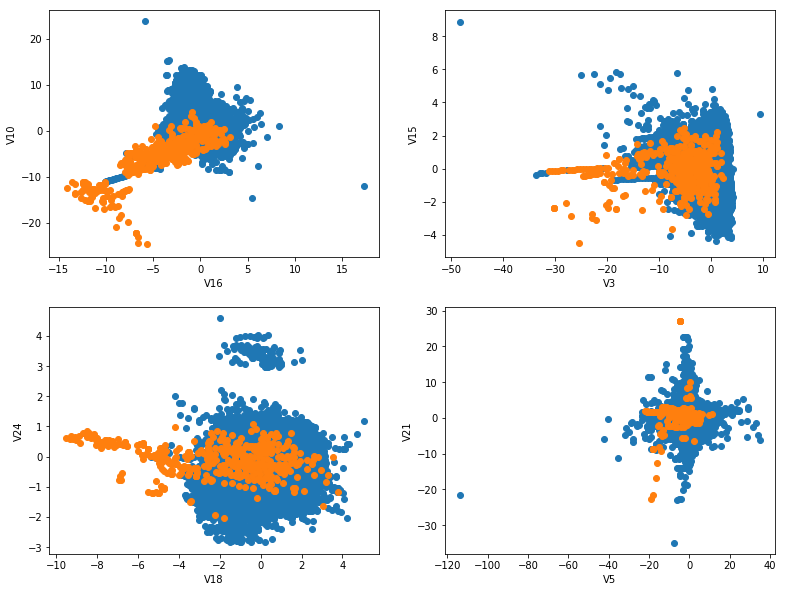

In [4]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)

### Prep data

In [5]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00172924575918
0.00172044520909


In [6]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_class(train)]
test_x, test_y = [df.as_matrix() for df in split_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [7]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.99827955479091324

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [8]:
from sklearn.metrics import recall_score
print "Recall:"
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Sampling methods

We are going to use Logistic Regression because it was the best performing classifiers according to preliminary exploration.

In [9]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [10]:
# best results from hyper parameter search
C_best = 0.001
logit_params          = {'penalty': 'l2', 'C': C_best}
logit_params_balanced = {'penalty': 'l2', 'C': C_best, 'class_weight':'balanced'}

In [11]:
models = []
labels = []

### Baseline

In [12]:
baseline = run_model(LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(baseline)
labels.append('Baseline')

---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.69      0.46      0.55        98

avg / total       1.00      1.00      1.00     56962

Geometric mean:	0.677511749752
Confusion mat: 
[[56844    20]
 [   53    45]]


The baseline is pretty poor with regard to geometric mean. Recall for the majority class is great of course, but not so great for the minorty class

### Over sampling

In [13]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227451), (1, 227451)]


In [14]:
resampled = run_model_sampler(RandomOverSampler, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('Oversampling')

Sampler: RandomOverSampler
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56864
          1       0.06      0.90      0.11        98

avg / total       1.00      0.98      0.99     56962

Geometric mean:	0.936257282574
Confusion mat: 
[[55510  1354]
 [   10    88]]


### Under sampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 394), (1, 394)]


In [16]:
resampled = run_model_sampler(RandomUnderSampler, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('Undersampling')

Sampler: RandomUnderSampler
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56864
          1       0.11      0.85      0.19        98

avg / total       1.00      0.99      0.99     56962

Geometric mean:	0.914667784503
Confusion mat: 
[[56171   693]
 [   15    83]]


### SMOTE/ADASYN oversampling

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE(kind='regular').fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227451), (1, 227451)]


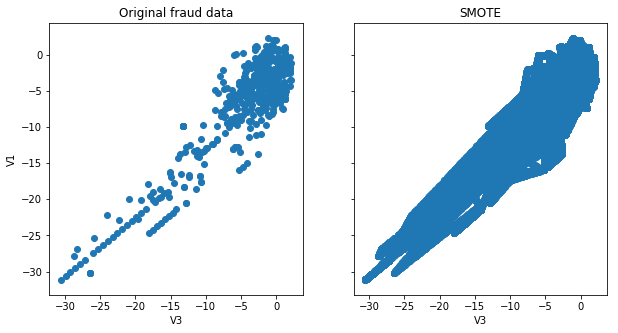

In [18]:
minorty = train_x_res[train_y_res == 1]
col_names = fradulent.columns
cols = (1,3)

fig, axarr = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax_orig = axarr[0]
ax_smote = axarr[1]

ax_orig.scatter(fradulent[col_names[cols[0]]],fradulent[col_names[cols[1]]])
ax_orig.set_title('Original fraud data')
ax_orig.set_ylabel(col_names[cols[0]])
ax_orig.set_xlabel(col_names[cols[1]])

ax_smote.scatter(minorty[:,cols[0]], minorty[:,cols[1]])
ax_smote.set_title('SMOTE')
ax_smote.set_xlabel(col_names[cols[1]])

plt.show()

In [19]:
resampled = run_model_sampler(SMOTE, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('SMOTE')

Sampler: SMOTE
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56864
          1       0.09      0.89      0.17        98

avg / total       1.00      0.99      0.99     56962

Geometric mean:	0.935239183065
Confusion mat: 
[[56026   838]
 [   11    87]]


In [20]:
resampled = run_model_sampler(ADASYN, LogisticRegression, train_x, train_y, test_x, test_y, **logit_params)
models.append(resampled)
labels.append('ADASYN')

Sampler: ADASYN
---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56864
          1       0.06      0.92      0.11        98

avg / total       1.00      0.97      0.99     56962

Geometric mean:	0.945949414327
Confusion mat: 
[[55406  1458]
 [    8    90]]


### Model weights

In [21]:
balanced = run_model(LogisticRegression, train_x, train_y, test_x, test_y, **logit_params_balanced)
models.append(balanced)
labels.append('Balanced')

---LogisticRegression---
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56864
          1       0.06      0.92      0.12        98

avg / total       1.00      0.98      0.99     56962

Geometric mean:	0.947254602234
Confusion mat: 
[[55559  1305]
 [    8    90]]


###  Ranking Performance

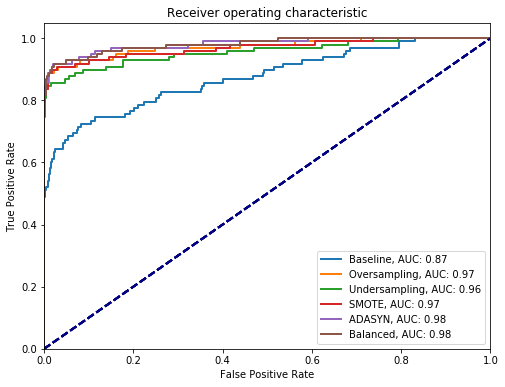

In [22]:
plot_many_roc(models, labels, test_x, test_y)

All the methods solidly outperform the baseline, though for the most part their performance is hard to distinguish from each other here. 

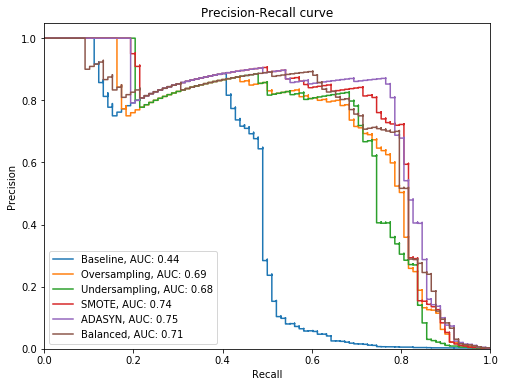

In [23]:
plot_many_pr(models, labels, test_x, test_y)

SMOTE and ADASYN have the high AUC scores, although many seem to perform similarly in the high-recall/low precision region we would choose to operate in. Class balanced model and oversampling follow.

In [24]:
from IPython.display import display
gms = [geometric_mean_score(test_y, m.predict(test_x)) for m in models]
f1s = [f1_score(test_y, m.predict(test_x)) for m in models]

In [25]:
cmap = plt.get_cmap('viridis')
# cmap = plt.get_cmap('tab20')
n = len(models)
interval = len(cmap.colors)/n
idxs = interval*np.ones(n).cumsum()
colors = np.array(cmap.colors)[idxs.astype(int)]

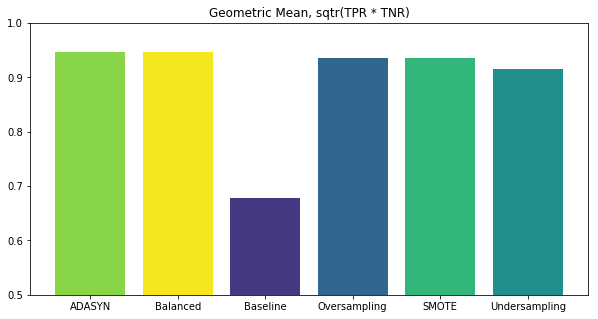

{'ADASYN': 0.94594941432698365,
 'Balanced': 0.94725460223399971,
 'Baseline': 0.67751174975189621,
 'Oversampling': 0.93625728257352381,
 'SMOTE': 0.93523918306472908,
 'Undersampling': 0.91466778450267328}

In [26]:
# colors = np.random.rand(len(models),3)
plt.figure(figsize=(10,5))
plt.bar(labels,gms,color=colors)
plt.ylim([0.5,1])
plt.title('Geometric Mean, sqtr(TPR * TNR)')
plt.show()

display({l:g for l,g in zip(labels,gms)})

As expected the baseline performance is bad by this metric, since geometric mean is representative metric for what we are trying to do: maximize both the TPR and TNR.

#### Conclusion

Based on the above plots we can conclude that all of the proposed methods are improvements on the baseline. SMOTE performs well in all plots, followed probably by ADASYN or the 'balanced' case. Balanced had a slightly better geometric mean, which is our primary metric, as well as in F1 Score; however ADASYN potentially outperformed balanced in the ROC and PR curves. Oversampling and undersampling appear to be inferior to other methods. Undersampling seems especially seems bad by the PR curve--perhaps this is explained by the fact that you are losing information to work with.